In [1]:
cd ../..

/disk1/home/svo6059/masters/spikelearn


# Environment

## Imports

In [2]:
import numpy as np
from spikelearn import bootstrapping as bs
from spikelearn.data import io, select, to_feature_array
from spikelearn.models.shuffle_decoding import shuffle_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import warnings

In [3]:
import pandas as pd
from sklearn.model_selection import cross_validate, GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_validate

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr
pearson = lambda t, p: pearsonr(t, p)[0]

from sklearn.model_selection import GroupShuffleSplit

from spikelearn.data.selection import select, to_feature_array, frankenstein
from spikelearn.data import io, SHORTCUTS
from spikelearn.models import shuffle_val_predict
from sklearn.metrics import make_scorer, cohen_kappa_score

In [4]:
from sklearn.linear_model import BayesianRidge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Functions

In [13]:
scoring={'Explained variance':'explained_variance', "Pearson's r":make_scorer(pearson)}

def cross_val(df, clf, n_splits=100):
    res = cross_validate(clf, df.values, df.reset_index().time, df.reset_index().trial, 
                         cv = GroupShuffleSplit(n_splits), scoring=scoring, return_train_score=False)

    res = pd.DataFrame(res).filter(regex='test').melt()
    res.variable = res.variable.apply(lambda s: s[5:])
    return res

# Null hypothesis via Bootstrap

## Analysis

In [6]:
stats = lambda r: r.groupby('variable').mean().reset_index()

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    res = pd.DataFrame()
    for rat in SHORTCUTS['groups']['DRRD']:
        data = to_feature_array(select(io.load(rat, 'wide_smoothed'), _min_duration=1.5, ))
        fanalysis = lambda df: cross_val(df.set_index(['trial', 'time']), LinearDiscriminantAnalysis())
        local =  bs.bootstrapping_analysis(data.reset_index(), analysis=fanalysis,
                                           shuffler= bs.df_shuffler, n_bootstrap=1000, statistics=stats, agg=pd.concat)
        local['subject'] = rat
        local['model'] = 'LDA'
        res = res.append(local)
        
        fanalysis = lambda df: cross_val(df.set_index(['trial', 'time']), BayesianRidge())
        local =  bs.bootstrapping_analysis(data.reset_index(), analysis=fanalysis,
                                           shuffler= bs.df_shuffler, n_bootstrap=1000, statistics=stats, agg=pd.concat)
        local['subject'] = rat
        local['model'] = 'Bayesian Ridge'
        res = res.append(local)

KeyboardInterrupt: 

In [ ]:
import pickle
pickle.dump(res, open('data/results/central_figures/pearson_vs_var.pickle', 'wb'))

In [ ]:
import pickle
res = pickle.load(open('data/results/central_figures/pearson_vs_var.pickle', 'rb'))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=200)

sns.boxplot(x='model', y='value', data=bootres[bootres.variable=="Pearson's r"], ax=ax[0])
sns.boxplot('model', 'value', data=bootres[bootres.variable=="Explained variance"], ax=ax[1])

ax[0].set_ylabel("Pearson's r")
ax[1].set_ylabel("Explained variance")
plt.tight_layout()

### To latex

In [ ]:
bootres=res

In [ ]:
q25 = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.quantile(.05))
q25.name='low'

q75 = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.quantile(.95))
q75.name='high'

qmin = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.min())
qmin.name='min'

qmax = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.max())
qmax.name='max'

# br = pd.merge(pd.DataFrame(q25), pd.DataFrame(q75), on=['subject', 'model', 'variable'])

In [ ]:
pd.concat([pd.DataFrame(qmin), pd.DataFrame(q25), pd.DataFrame(q75), pd.DataFrame(qmax)], axis=1).T.round(3)

In [ ]:
print(pd.concat([pd.DataFrame(qmin), pd.DataFrame(q25), 
                 pd.DataFrame(q75), pd.DataFrame(qmax)], axis=1)
      .T.round(3).to_latex())

# H1 hypothesis

## Analysis

In [10]:
analysis = lambda df, clf: cross_val(df, clf)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    res = pd.DataFrame()
    for rat in SHORTCUTS['groups']['DRRD']:
        data = to_feature_array(select(io.load(rat, 'wide_smoothed'), _min_duration=1.5, ))
        %time local = analysis(data, LinearDiscriminantAnalysis() )
        local['subject'] = rat
        local['model'] = 'LDA'
        res = res.append(local)
        
        %time local = analysis(data, BayesianRidge() )
        local['subject'] = rat
        local['model'] = 'Bayesian Ridge'
        res = res.append(local)
#     res.variable = res.variable.apply(lambda s: s[5:])

CPU times: user 6min 4s, sys: 3min 45s, total: 9min 50s
Wall time: 17.7 s
CPU times: user 3min 48s, sys: 3min 18s, total: 7min 6s
Wall time: 10.9 s
CPU times: user 4min 38s, sys: 3min 27s, total: 8min 6s
Wall time: 12.9 s
CPU times: user 1min 39s, sys: 1min 32s, total: 3min 12s
Wall time: 4.91 s
CPU times: user 5min 37s, sys: 3min 45s, total: 9min 22s
Wall time: 16.1 s
CPU times: user 3min 20s, sys: 3min 3s, total: 6min 23s
Wall time: 9.89 s
CPU times: user 6min 59s, sys: 3min 49s, total: 10min 49s
Wall time: 23.1 s
CPU times: user 3min 35s, sys: 3min 18s, total: 6min 53s
Wall time: 10.6 s


## Score figures

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


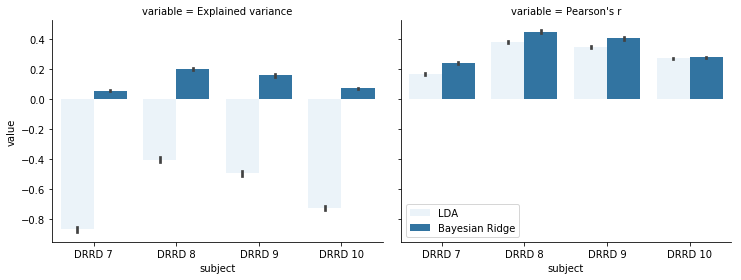

In [11]:
g = sns.FacetGrid(res, col='variable', height=4, aspect=1.3)
g.map(sns.barplot, 'subject', 'value', 'model')
plt.legend()

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


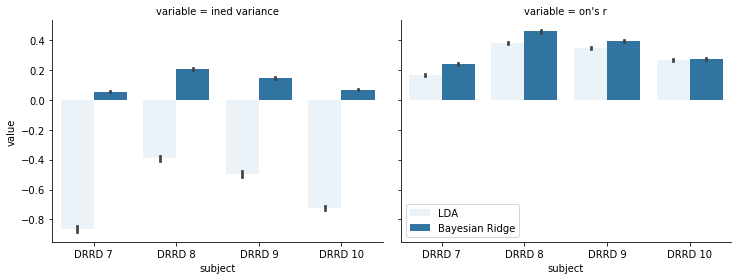

In [7]:
g = sns.FacetGrid(res, col='variable', height=4, aspect=1.3)
g.map(sns.barplot, 'subject', 'value', 'model')
plt.legend()

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


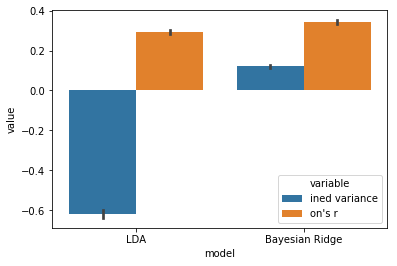

In [8]:
sns.barplot(y='value', x='model', hue='variable', data=res)

## Prediction figures

In [5]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import explained_variance_score, confusion_matrix

In [150]:
clf = LinearDiscriminantAnalysis()
X,y, trial = to_feature_array(select(io.load('DRRD 10', 'wide_smoothed'), _min_duration=1.5, ), True)
preds = cross_val_predict(clf, X, y, trial, cv=5)
explained_variance_score(y, preds)

-0.7522753419766519

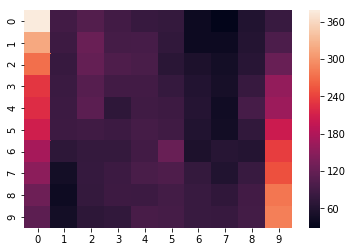

In [169]:
sns.heatmap(confusion_matrix(y, preds))

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/di

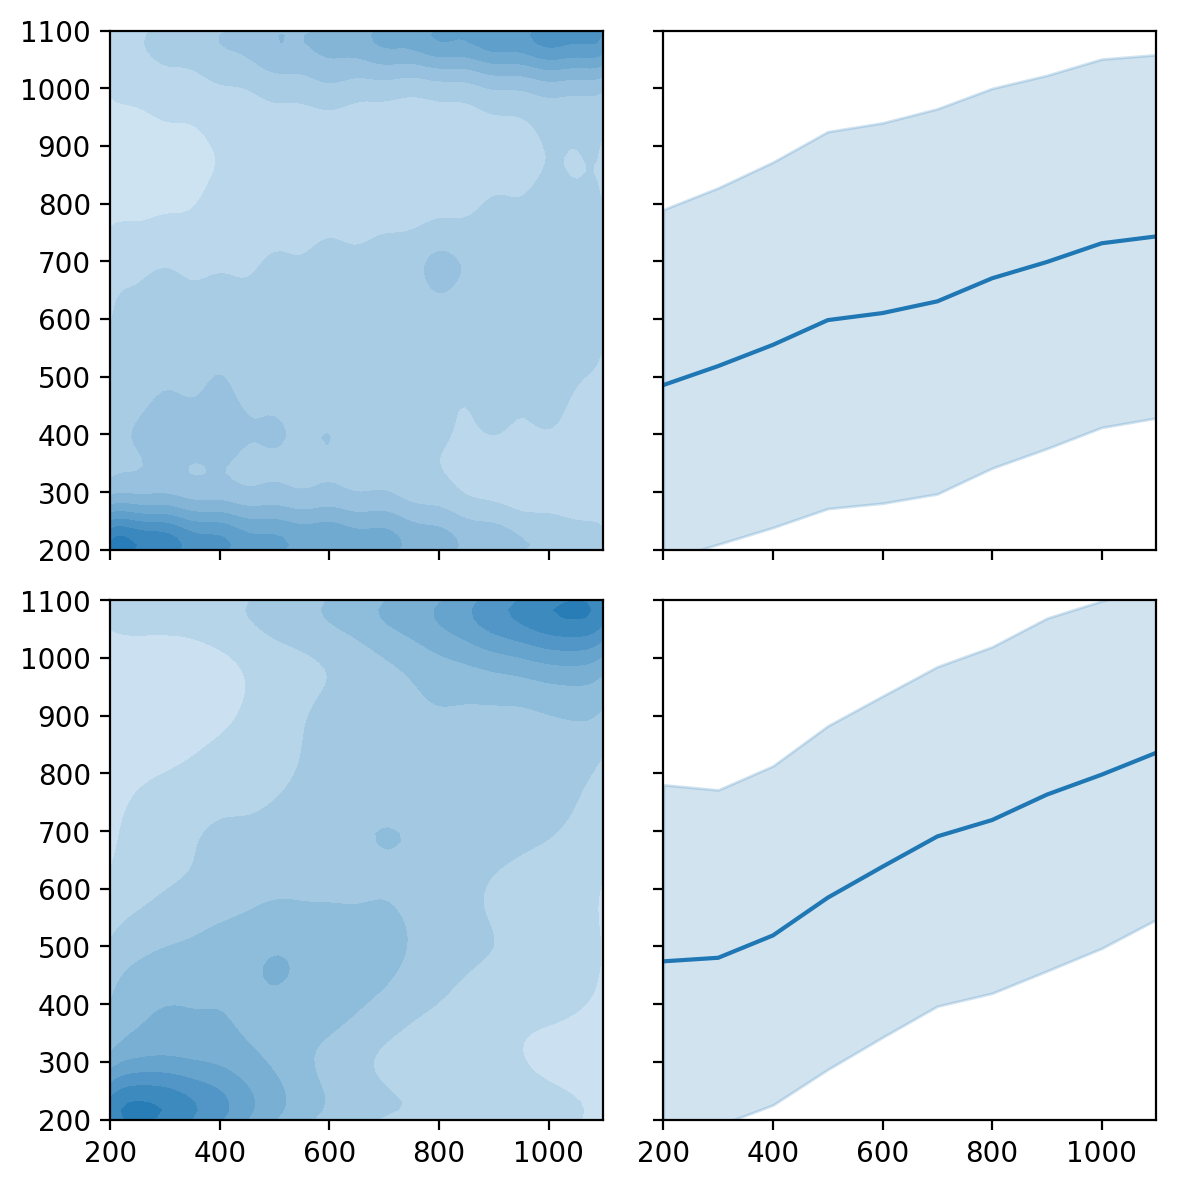

In [8]:
fig, ax = plt.subplots(2,2, figsize=(6,6), dpi=200, sharey=True, sharex=True)
clf = LinearDiscriminantAnalysis()

# Bad rat
X,y, trial = to_feature_array(select(io.load('DRRD 10', 'wide_smoothed'), _min_duration=1.5, ), True)
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[0, 0])
sns.lineplot(y, preds, ax=ax[0, 1], ci='sd')

# Good rat
X,y, trial = to_feature_array(select(io.load('DRRD 8', 'wide_smoothed'), _min_duration=1.5, ), True)
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[1, 0])
sns.lineplot(y, preds, ax=ax[1, 1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()

In [ ]:
%%time
fig, ax = plt.subplots(2,2, figsize=(6,6), dpi=200, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
X,y, trial = to_feature_array(select(io.load('DRRD 10', 'wide_smoothed'), _min_duration=1.5), True, 'full')
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[0, 0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[0, 1], ci='sd')

# Good rat
X,y, trial = to_feature_array(select(io.load('DRRD 8', 'wide_smoothed'), _min_duration=1.5, ), True, 'full')
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[1, 0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1, 1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()
# plt.suptitle('Regression results')

### Overkilling with catboost

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Regression results')

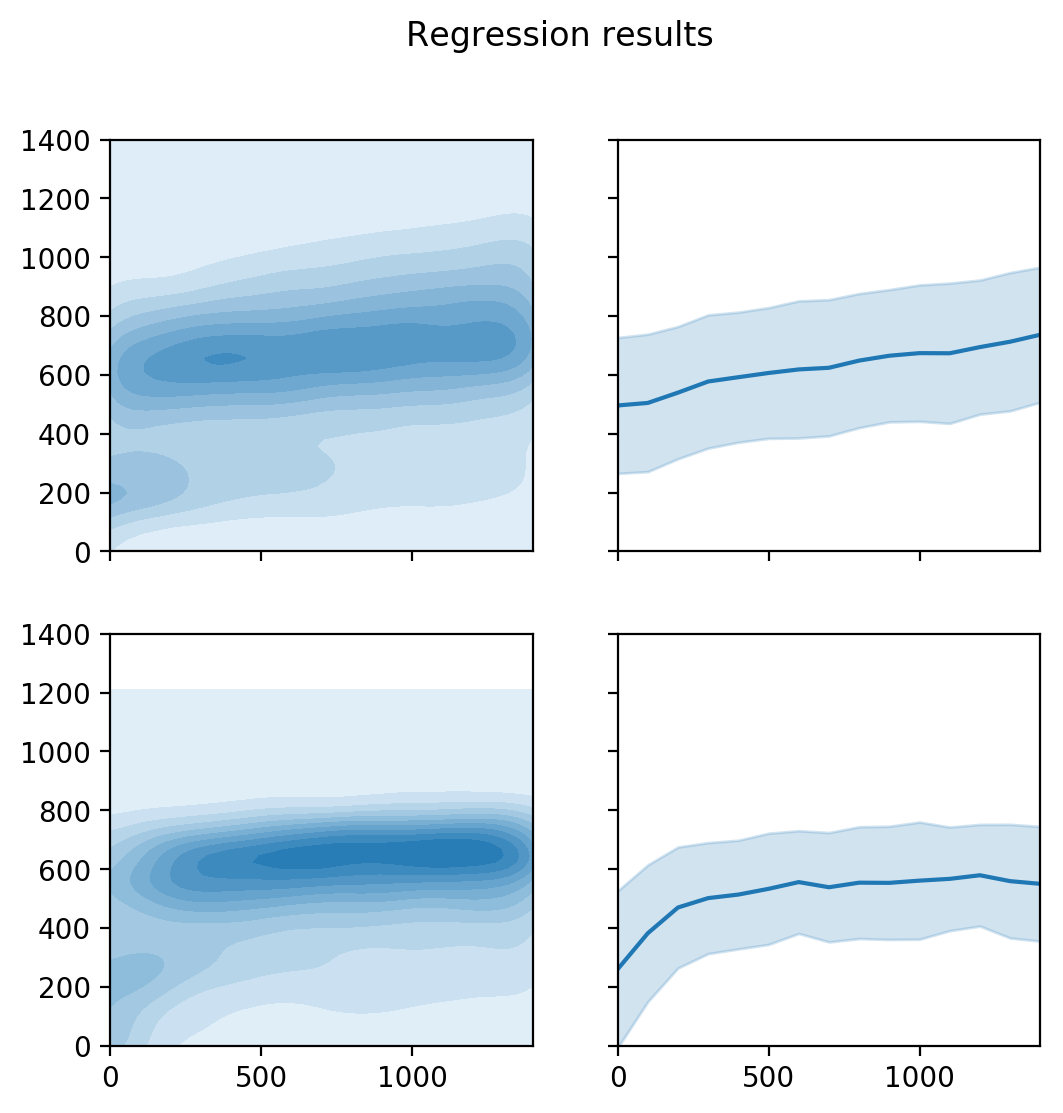

In [8]:
from catboost import CatBoostRegressor
fig, ax = plt.subplots(2,2, figsize=(6,6), dpi=200, sharey=True, sharex=True)
clf = CatBoostRegressor(verbose=False)

# Bad rat
X,y, trial = to_feature_array(select(io.load('DRRD 10', 'no_smoothing'), _min_duration=1.5, ), True, 'full')
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[0, 0])
sns.lineplot(y, preds, ax=ax[0, 1], ci='sd')

# Good rat
X,y, trial = to_feature_array(select(io.load('DRRD 8', 'no_smoothing'), _min_duration=1.5, ), True, 'full')
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[1, 0])
sns.lineplot(y, preds, ax=ax[1, 1], ci='sd')

plt.ylim([0,1400])
plt.xlim([0,1400])
plt.suptitle('Regression results')

### Normalized

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Regression results')

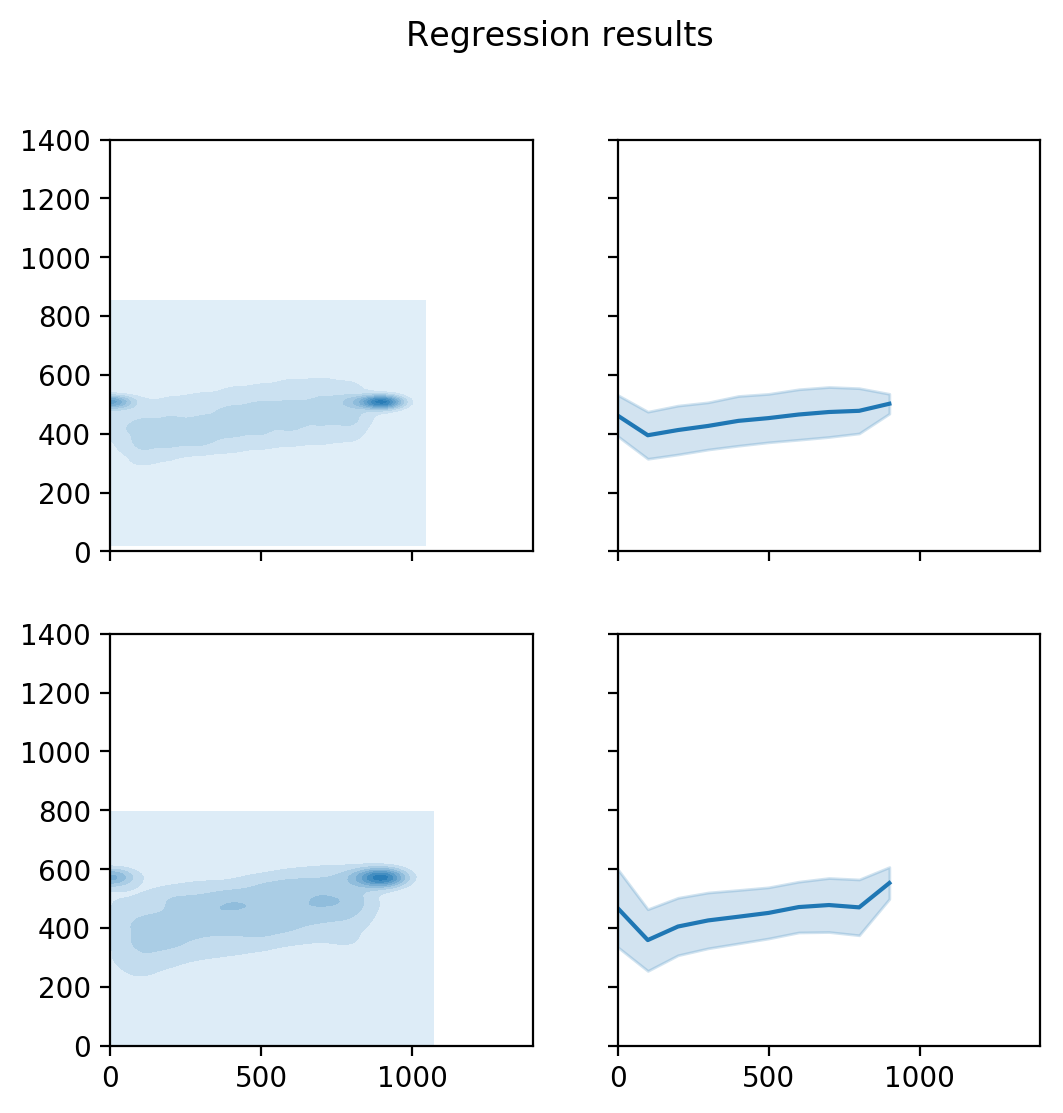

In [11]:
from catboost import CatBoostRegressor
fig, ax = plt.subplots(2,2, figsize=(6,6), dpi=200, sharey=True, sharex=True)
clf = CatBoostRegressor(verbose=False)

# Bad rat
X,y, trial = to_feature_array(select(io.load('DRRD 10', 'no_smoothing_norm'), _min_duration=1.5, ), True, 'cropped')
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[0, 0])
sns.lineplot(y, preds, ax=ax[0, 1], ci='sd')

# Good rat
X,y, trial = to_feature_array(select(io.load('DRRD 8', 'no_smoothing_norm'), _min_duration=1.5, ), True, 'cropped')
preds = cross_val_predict(clf, X, y, trial, cv=5)

sns.kdeplot(y, preds, shade=True, ax=ax[1, 0])
sns.lineplot(y, preds, ax=ax[1, 1], ci='sd')

plt.ylim([0,1400])
plt.xlim([0,1400])
plt.suptitle('Regression results')

# Explanations

In [9]:
from shap import TreeExplainer

ModuleNotFoundError: No module named 'shap'

In [ ]:
for rat in SHORTCUTS['groups']['DRRD']:
    X,y, trial = to_feature_array(select(io.load('DRRD 8', 'no_smoothing_norm'), _min_duration=1.5, ), True, 'full')